In [21]:
import os, shutil
from os import listdir
from os.path import isfile, join
import random

In [22]:
print(os.getcwd())

#creo lista di nomi 
directories = ['data/train/', 
               'data/val/', 
               'data/test/']

train_file_names = [f for f in listdir(directories[0]) if isfile(join(directories[0], f))]
val_file_names = [f for f in listdir(directories[1]) if isfile(join(directories[1], f))]
test_file_names = [f for f in listdir(directories[2]) if isfile(join(directories[2], f))]

_file_names = [train_file_names, val_file_names, test_file_names] 

/home/phil/Documents/FisicaUniMiB/Tesi/Source/Code


In [23]:
#numero immagini per categoria
scans = ['CT','MRI','PET']
numbers=[]
minimi=[]

for directory in directories:    
    for scan in scans:
        a = len([f for f in listdir(directory) if f[:2]==scan[:2]])
        #print('Numbero di immagini', scan, 'in', directory,':', a)
        numbers.append(a)
    minimi.append(min(numbers))

#print(minimi)
#=> è sempre la PET che ha il numero minore

In [24]:
#creo la lista di file bilanciata: n.b  la percentuale viene mantenuta
train_final_file_names=[]
val_final_file_names=[]
test_final_file_names=[]
_final_file_names = [train_final_file_names, val_final_file_names, test_final_file_names] 

l=[]
for directory,minimo,name in zip(directories, minimi,_final_file_names):    
    for scan in scans:
        l = [f for f in listdir(directory) if f[:2]==scan[:2]]
        random.shuffle(l)
        l = l[:minimo]
        name.extend(l) #estendo la lista (don't append)
        
# How I cicled ^^^

#    minimo |
#    name   |
#    train  | val | test
# 
# CT    ... | ... | ...
# MRI   ... | ... | ...
# PET   ... | ... | ...

In [25]:
print("DATASET")
print("Training", len(train_final_file_names), ", Validation:", len(val_final_file_names) ,", Test:", len(test_final_file_names))

DATASET
Training 975 , Validation: 342 , Test: 171


## Converto le immagini in tensori

In [26]:
from skimage import io
import matplotlib.pyplot as plt
import cv2

### X

In [27]:
def WriteAndArrayImages(path):
    x = io.imread(path[random.randint(0,10)])
    x = cv2.resize(x, dsize=(128,128))
    
    for img in path[1:]:
        img = io.imread(img)
        img = cv2.resize(img, dsize=(128,128))
        x = np.dstack((x,img))
    x = np.rollaxis(x,-1)
    return x

(975, 128, 128)
(342, 128, 128)
(171, 128, 128)


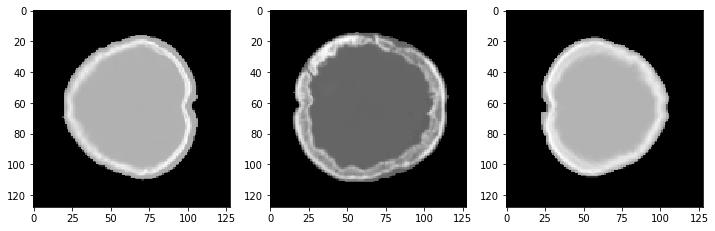

In [28]:
import numpy as np

#paths per leggere le immagini
train_paths=[]
val_paths=[]
test_paths=[]
_paths=[train_paths,val_paths,test_paths]

for path,name,directory in zip(_paths,_final_file_names,directories):
    for f in name:
        path.append(directory+f)

#leggo le immagini e le stacco una sopra l'altra
x_train = WriteAndArrayImages(train_paths)
x_val = WriteAndArrayImages(val_paths)
x_test = WriteAndArrayImages(test_paths)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

#plot images from each dataset
f, axarr = plt.subplots(1,3,figsize=(12, 12))
axarr[0].imshow(x_train[random.randint(0,100)], cmap=plt.cm.gray)
axarr[1].imshow(x_val[random.randint(0,100)], cmap=plt.cm.gray)
axarr[2].imshow(x_test[random.randint(0,100)], cmap=plt.cm.gray)

### Y

In [29]:
def MakeLabels(_name_files):
    y=[]
    for text in _name_files:
        fileNameOnly = text[:text.find(ext)]
        y.append(''.join([i for i in fileNameOnly if not i.isdigit()]))
    for i, item in enumerate(y):
        if item == 'CT':
            y[i] = 0
        elif item == 'MRI':
            y[i] = 1
        else: y[i] = 2    
    y = np.concatenate((y,))
    return y

In [30]:
#estensione immagini
ext = '.png'

#costruisco le lables
y_train = MakeLabels(_final_file_names[0])
y_val = MakeLabels(_final_file_names[1])
y_test = MakeLabels(_final_file_names[2])

In [31]:
#check
X = [x_train, x_val, x_test]
Y = [y_train, y_val, y_test]

for x,y in zip(X,Y):
    if len(x) != len(y):
        print(len(x))
        print(len(y))
        print('Error! La lunghezza delle liste non combacia!')
    else: 
        print('Ok, le lunghezze combaciano con le X')

#controlla numero di cluster (expected 3)
n_clusters = len(np.unique(y))
print('Clusters:', n_clusters)

Ok, le lunghezze combaciano con le X
Ok, le lunghezze combaciano con le X
Ok, le lunghezze combaciano con le X
Clusters: 3


## Autoencoder Model 
N.B. Execute only the model you want to train 

In [32]:
from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model

### Convolutional Autoencoder Model

In [33]:
def autoencoderConv2D_1(input_shape=(128, 128, 1), filters=[32, 64, 128, 1024, 3]):
    input_img = Input(shape=input_shape)
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)

    x = Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2')(x)

    x = Conv2D(filters[2], 3, strides=2, padding='same', activation='relu', name='conv3')(x)
    
    x = Flatten()(x)
    
    encoded = Dense(units=filters[3], name='embedding')(x)
    
    y = Dense(units=filters[4], name='output_to_cluster')(encoded)
    
    x = Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu')(encoded)

    x = Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2]))(x)
    
    x = Conv2DTranspose(filters[1], 3, strides=2, padding='same', activation='relu', name='deconv3')(x)

    x = Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1')(x)
    
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=y, name='encoder')

In [34]:
autoencoder, encoder = autoencoderConv2D_1()

print('ENCODER')
encoder.summary()

print('AUTOENCODER')
autoencoder.summary()

ENCODER
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 128)       73856     
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
embedding (Dense)            (None, 1024)              33555456  
_________________________________________________________________
output_to_cluster (Dense)    (None, 3)                 3075      
To

### Reshape Arrays for AE

In [35]:
#use this function for reshaping arrays for CAE
def ReshapeCAE(array):
    array = array.reshape(array.shape + (1,))
    array = array/255.
    return array

x_train = ReshapeCAE(x_train)
x_val = ReshapeCAE(x_val)
x_test = ReshapeCAE(x_test)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(975, 128, 128, 1)
(342, 128, 128, 1)
(171, 128, 128, 1)


### Clustering Layer

In [36]:
from keras.engine.topology import Layer

class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Pretrain

### Hyperparameters (to edit)

In [37]:
from keras.initializers import VarianceScaling
from keras.optimizers import SGD

init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')

pretrain_epochs = 50 #####
batch_size = 16 #####

In [38]:
#dir results
save_dir = './results'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
from keras.callbacks import TensorBoard

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(x_train, 
                x_train, 
                batch_size=batch_size, 
                epochs=pretrain_epochs, 
                validation_data=(x_val, x_val),
                #callbacks=[TensorBoard(log_dir='/tmp/autoencoder')]
               )

autoencoder.save_weights(save_dir+'/conv_ae_weights.h5')

Train on 975 samples, validate on 342 samples
Epoch 1/50
975/975 [==============================] - 138s 141ms/step - loss: 0.0228 - val_loss: 0.0079
Epoch 2/50
975/975 [==============================] - 125s 128ms/step - loss: 0.0079 - val_loss: 0.0055
Epoch 3/50
975/975 [==============================] - 122s 125ms/step - loss: 0.0066 - val_loss: 0.0059
Epoch 4/50
975/975 [==============================] - 122s 125ms/step - loss: 0.0062 - val_loss: 0.0037
Epoch 5/50
975/975 [==============================] - 122s 125ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 6/50
975/975 [==============================] - 125s 128ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 7/50
975/975 [==============================] - 121s 124ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 8/50
975/975 [==============================] - 119s 122ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 9/50
975/975 [==============================] - 119s 122ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 10/50
975/97

In [20]:
autoencoder.load_weights(save_dir+'/conv_ae_weights.h5')

ValueError: Dimension 1 in both shapes must be equal, but are 1024 and 256. Shapes are [32768,1024] and [32768,256]. for 'Assign_6' (op: 'Assign') with input shapes: [32768,1024], [32768,256].

tensorboard --logdir=/tmp/autoencoder

### Plot train and validation loss 

In [ ]:
#plot train and validation loss of pretraining
plt.plot(autoencoder.history.history['loss'])
plt.plot(autoencoder.history.history['val_loss'])
plt.title('AE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

### Show prediction after pretraining CAE

In [151]:
#predict images and display

directories = ['data/train/', 
               'data/val/', 
               'data/test/']

scans=['CT','MRI','PET']

def PickListImagesPerType(directory,scan):
    names = [f for f in listdir(directory) if f[:2]==scan[:2]]
    return names

def PickOneImage(names,directory,n):
    image = io.imread(directory+names[n])
    image = cv2.resize(image, dsize=(128,128))
    return image

In [152]:
#image layer to display (change this to display different images and respective decoded ones)
n = 5

### Prediction on test dataset

In [153]:
#ORIGINAL IMAGES
#pick one image per type of scan
imgsCT = PickOneImage(PickListImagesPerType(directories[0],scans[0]),directories[0],n)
imgsMRI = PickOneImage(PickListImagesPerType(directories[0],scans[1]),directories[0],n)
imgsPET = PickOneImage(PickListImagesPerType(directories[0],scans[2]),directories[0],n)

#DECODED IMAGES
#costruisco la lista di immagini da decodificare
listaCT=[]
for f in PickListImagesPerType(directories[0],scans[0]): 
    listaCT.append(join(directories[0], f))

listaMRI=[]
for f in PickListImagesPerType(directories[0],scans[1]): 
    listaMRI.append(join(directories[0], f))
    
listaPET=[]
for f in PickListImagesPerType(directories[0],scans[2]): 
    listaPET.append(join(directories[0], f))

#decode images per type of scan
decoded_imgsCT = autoencoder.predict(ReshapeCAE(WriteAndArrayImages(listaCT)))
decoded_imgsMRI = autoencoder.predict(ReshapeCAE(WriteAndArrayImages(listaMRI)))
decoded_imgsPET = autoencoder.predict(ReshapeCAE(WriteAndArrayImages(listaPET)))

#select one decoded image and make in plottable
decoded_imgCT = decoded_imgsCT[n].reshape(128,128)
decoded_imgMRI = decoded_imgsMRI[n].reshape(128,128)
decoded_imgPET = decoded_imgsPET[n].reshape(128,128)

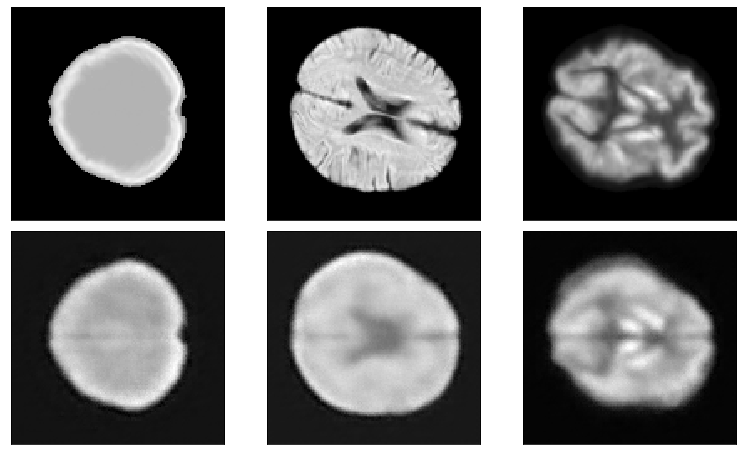

In [154]:
fig = plt.figure(figsize=(13,10))

#plot images
ax = plt.subplot(2,3,1)
plt.imshow(imgsCT)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,2)
plt.imshow(imgsMRI)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,3)
plt.imshow(imgsPET)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,4)
plt.imshow(decoded_imgCT)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,5)
plt.imshow(decoded_imgMRI)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,6)
plt.imshow(decoded_imgPET)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.subplots_adjust(wspace=0.2, hspace=-0.3)

## DCEC Model

In [155]:
from keras.engine.topology import InputSpec

clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])

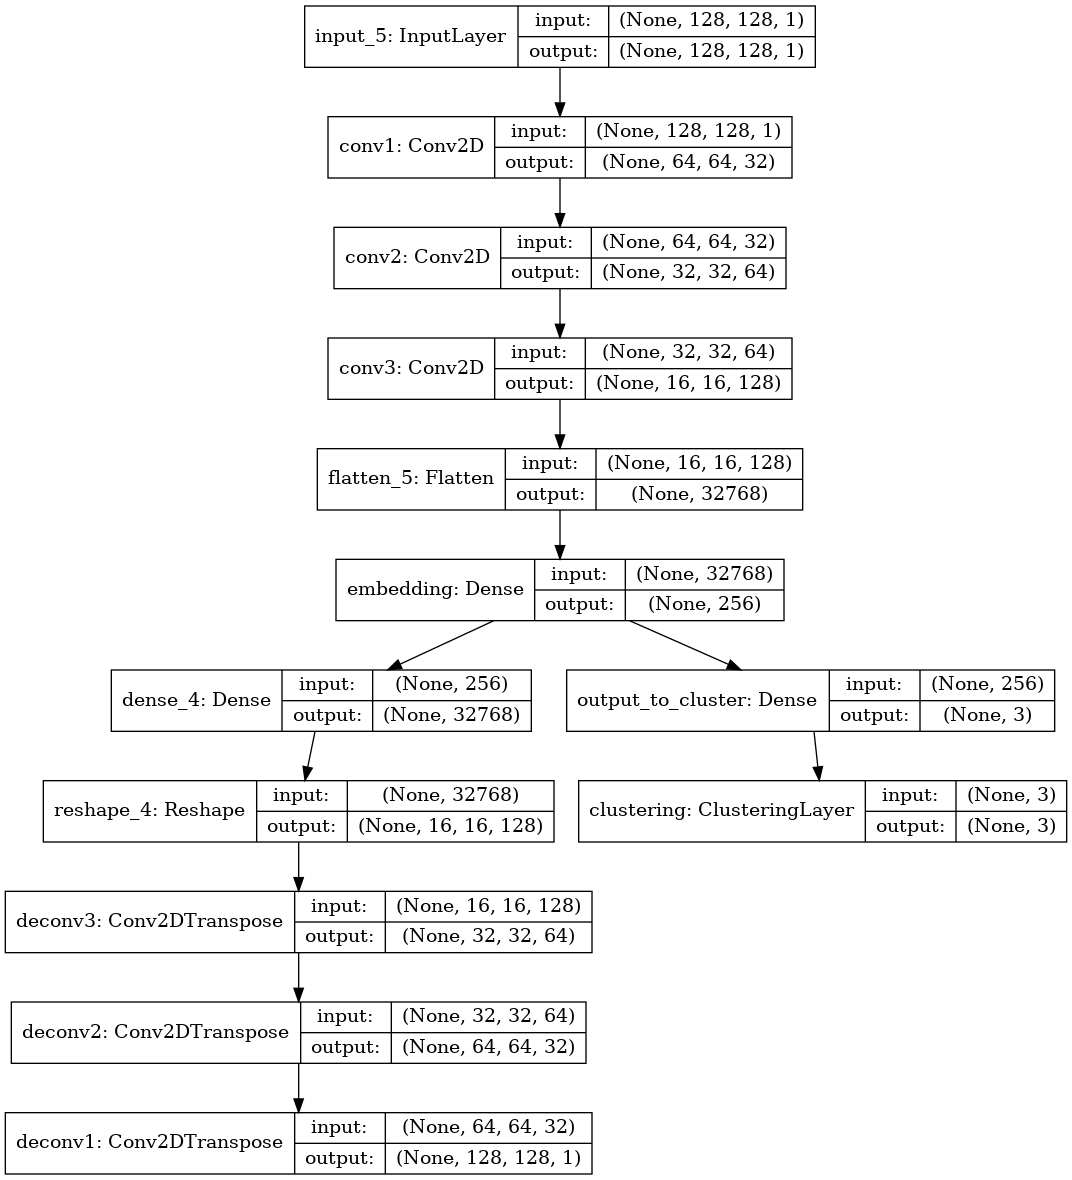

In [156]:
from keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='DCEC_model.png', show_shapes=True)
Image(filename='DCEC_model.png')

## Inizialize cluster centers using k-means

In [157]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x_train))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

y_pred_last = np.copy(y_pred)

In [158]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

## Training

### Deep clustering

In [159]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

#for plotting
lista_train_losses = [[],[],[]]
lista_val_losses = [[],[],[]]
iterazione=[]

train_loss = [0,0,0]
val_loss = [0,0,0]
index = 0
maxiter = 100
update_interval = 1
train_index_array = np.arange(x_train.shape[0])
val_index_array = np.arange(x_val.shape[0])

tol = 0.001 # tolerance threshold to stop training

### Start training

In [160]:
import metrics
from IPython.core.debugger import set_trace
#set_trace()


for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _ = model.predict(x_train, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y_train is not None:
            acc = np.round(metrics.acc(y_train, y_pred), 5)
            nmi = np.round(metrics.nmi(y_train, y_pred), 5)
            ari = np.round(metrics.ari(y_train, y_pred), 5)
            train_loss = np.round(train_loss, 5)
            val_loss = np.round(val_loss, 5)
            print('Iter', ite, ': Acc', acc, ', nmi', nmi, ', ari', ari, '; train_loss=', train_loss, ';val_loss=', val_loss) 

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    
    # train on batch
    idx_train = train_index_array[index * batch_size: min((index+1) * batch_size, x_train.shape[0])]
    train_loss = model.train_on_batch(x=x_train[idx_train], y=[p[idx_train], x_train[idx_train]])
    lista_train_losses[0].append(train_loss[0])
    lista_train_losses[1].append(train_loss[1])
    lista_train_losses[2].append(train_loss[2])
    
    idx_val = val_index_array[index * batch_size: min((index+1) * batch_size, x_val.shape[0])]
    val_loss = model.test_on_batch(x=x_val[idx_val], y=[p[idx_val], x_val[idx_val]])
    lista_val_losses[0].append(val_loss[0])
    lista_val_losses[1].append(val_loss[1])
    lista_val_losses[2].append(val_loss[2])
    
    index = index + 1 if (index + 1) * batch_size <= x_train.shape[0] else 0
    
    iterazione.append(ite)
    

# save the trained model
print('saving model to:', save_dir + '/dcec_model_final.h5')
model.save_weights(save_dir + '/dcec_model_final.h5')

/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 0 : Acc 0.41333 , nmi 0.03696 , ari 0.01389 ; train_loss= [0 0 0] ;val_loss= [0 0 0]


/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 1 : Acc 0.74667 , nmi 0.11689 , ari 0.19503 ; train_loss= [0.00909 0.06659 0.00243] ;val_loss= [0.06345 0.37677 0.02577]


/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 2 : Acc 0.52513 , nmi 0.02961 , ari -0.05104 ; train_loss= [0.02668 0.03918 0.02277] ;val_loss= [0.01882 0.14154 0.00467]


/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 3 : Acc 0.6041 , nmi 0.01465 , ari -0.05187 ; train_loss= [0.0076  0.01751 0.00585] ;val_loss= [0.02302 0.14961 0.00806]


/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 4 : Acc 0.60718 , nmi 0.01951 , ari -0.05712 ; train_loss= [0.01042 0.01542 0.00888] ;val_loss= [0.01721 0.10185 0.00702]


/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 5 : Acc 0.61128 , nmi 0.02498 , ari -0.04811 ; train_loss= [0.00887 0.02282 0.00659] ;val_loss= [0.03352 0.23246 0.01028]


/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 6 : Acc 0.62462 , nmi 0.01862 , ari -0.04923 ; train_loss= [0.01051 0.02267 0.00824] ;val_loss= [0.02827 0.22625 0.00564]


/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 7 : Acc 0.63692 , nmi 0.01681 , ari -0.04508 ; train_loss= [0.00715 0.01584 0.00556] ;val_loss= [0.01609 0.1236  0.00373]


/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 8 : Acc 0.61128 , nmi 0.0161 , ari -0.04984 ; train_loss= [0.00748 0.02202 0.00528] ;val_loss= [0.02417 0.21717 0.00245]


/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 9 : Acc 0.58154 , nmi 0.01854 , ari -0.05714 ; train_loss= [0.0093  0.03655 0.00565] ;val_loss= [0.03741 0.34747 0.00266]


/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 10 : Acc 0.53846 , nmi 0.02548 , ari -0.06754 ; train_loss= [0.00414 0.01217 0.00292] ;val_loss= [0.01241 0.08545 0.00386]


/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 11 : Acc 0.52205 , nmi 0.02322 , ari -0.06258 ; train_loss= [0.00867 0.03417 0.00525] ;val_loss= [0.02902 0.24391 0.00463]


/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 12 : Acc 0.49846 , nmi 0.02963 , ari -0.06071 ; train_loss= [0.00829 0.04012 0.00428] ;val_loss= [0.03649 0.34035 0.00246]


/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 13 : Acc 0.50051 , nmi 0.02912 , ari -0.05398 ; train_loss= [0.00788 0.04055 0.00382] ;val_loss= [0.02856 0.259   0.00266]


/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 14 : Acc 0.47692 , nmi 0.0369 , ari -0.03271 ; train_loss= [0.00693 0.03514 0.00341] ;val_loss= [0.02844 0.26061 0.00238]


/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 15 : Acc 0.47179 , nmi 0.04954 , ari 0.00375 ; train_loss= [0.00797 0.04073 0.0039 ] ;val_loss= [0.04098 0.3694  0.00404]


/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 16 : Acc 0.63077 , nmi 0.11219 , ari 0.14402 ; train_loss= [0.00882 0.0536  0.00346] ;val_loss= [0.07139 0.65477 0.00592]


/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 17 : Acc 0.57231 , nmi 0.09642 , ari 0.11155 ; train_loss= [0.01223 0.08746 0.00348] ;val_loss= [0.06762 0.62006 0.00561]


/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 18 : Acc 0.60103 , nmi 0.09401 , ari 0.13095 ; train_loss= [0.01552 0.11276 0.00424] ;val_loss= [0.10586 1.00921 0.00494]


/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 19 : Acc 0.61538 , nmi 0.09054 , ari 0.13353 ; train_loss= [0.01343 0.09053 0.00438] ;val_loss= [0.08588 0.81558 0.00432]


/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 20 : Acc 0.56103 , nmi 0.10309 , ari 0.08567 ; train_loss= [0.01247 0.09257 0.00322] ;val_loss= [0.09722 0.93174 0.00405]


/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 21 : Acc 0.4441 , nmi 0.0656 , ari 0.00623 ; train_loss= [0.01055 0.0687  0.00368] ;val_loss= [0.05524 0.50782 0.00446]


/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/phil/anaconda3/envs/tesi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 22 : Acc 0.45641 , nmi 0.04703 , ari -0.02362 ; train_loss= [0.00873 0.0593  0.0028 ] ;val_loss= [0.05433 0.49943 0.00439]


InvalidArgumentError: input and filter must have the same depth: 1 vs 32
	 [[{{node conv2_4/Relu}}]]

### Plot DCEC train and validation losses

NameError: name 'ite' is not defined

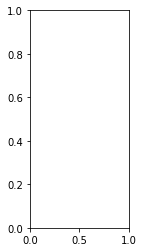

In [44]:
#plot
plt.subplot(1,3,1)
x1=iterazione
y1=lista_train_losses[0]
y2=lista_val_losses[0]
plt.plot(x1,y1)
plt.plot(x1,y2)
plt.title('L')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1,3,2)
x1=iterazione
y1=lista_train_losses[1]
y2=lista_val_losses[1]
plt.plot(x1,y1)
plt.plot(x1,y2)
plt.title('Lr')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1,3,3)
x1=iterazione
y1=lista_train_losses[2]
y2=lista_val_losses[2]
plt.plot(x1,y1)
plt.plot(x1,y2)
plt.title('Lc')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.show()

# Here put the final evaluation on test dataset: acc, loss

In [ ]:
model.evaluate(x=x_test, y=[p, x_test])

## Show prediction after pretraining DCEC

### Prediction on test dataset

In [ ]:
#image layer to display (change this to display different images and respective decoded ones)
n = 5 

#ORIGINAL IMAGES
#pick one image per type of scan
imgsCT = PickOneImage(PickListImagesPerType(directories[2],scans[0]),directories[2],n)
imgsMRI = PickOneImage(PickListImagesPerType(directories[2],scans[1]),directories[2],n)
imgsPET = PickOneImage(PickListImagesPerType(directories[2],scans[2]),directories[2],n)

#DECODED IMAGES
#costruisco la lista di immagini da decodificare
listaCT=[]
for f in PickListImagesPerType(directories[2],scans[0]): 
    listaCT.append(join(directories[2], f))

listaMRI=[]
for f in PickListImagesPerType(directories[2],scans[1]): 
    listaMRI.append(join(directories[2], f))
    
listaPET=[]
for f in PickListImagesPerType(directories[2],scans[2]): 
    listaPET.append(join(directories[2], f))

#decode images per type of scan
decoded_imgsCT = model.predict(ReshapeCAE(WriteAndArrayImages(listaCT)))[1]
decoded_imgsMRI = model.predict(ReshapeCAE(WriteAndArrayImages(listaMRI)))[1]
decoded_imgsPET = model.predict(ReshapeCAE(WriteAndArrayImages(listaPET)))[1]

#select one decoded image and make in plottable
decoded_imgCT = decoded_imgsCT[n].reshape(128,128)
decoded_imgMRI = decoded_imgsMRI[n].reshape(128,128)
decoded_imgPET = decoded_imgsPET[n].reshape(128,128)

#plot images
ax = plt.subplot(2,3,1)
plt.imshow(imgsCT)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,2)
plt.imshow(imgsMRI)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,3)
plt.imshow(imgsPET)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,4)
plt.imshow(decoded_imgCT)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,5)
plt.imshow(decoded_imgMRI)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,6)
plt.imshow(decoded_imgPET)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

## Plotting clusters

### Train

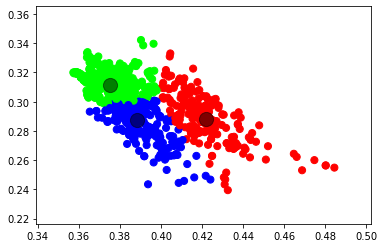

In [31]:
output_cluster = model.predict(x_train)[0]
y_pred = kmeans.fit_predict(model.predict(x_train)[0])
plt.scatter(output_cluster[:,0], output_cluster[:,1], c=y_pred, s=50, cmap='brg')
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5);

### Test

In [ ]:
output_cluster = model.predict(x_test)[0]
y_pred = kmeans.fit_predict(model.predict(x_test)[0])
plt.scatter(output_cluster[:,0], output_cluster[:,1], c=y_pred, s=50, cmap='brg')
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5);

## Confusion matrix

In [ ]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix([int(i) for i in y_test], y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Clustering label')
plt.show()

In [ ]:
from sklearn.utils.linear_assignment_ import linear_assignment

y_true = y.astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)

sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [ ]:
ind